In [2]:
# increase default window size for notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

C:\Users\s.kaiser\AppData\Local\Temp\ipykernel_19968\696421802.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
# Set reproducible results by random seeding, answer from here: https://stackoverflow.com/questions/50659482/why-cant-i-get-reproducible-results-in-keras-even-though-i-set-the-random-seeds

# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K

# for later versions:
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)
K.set_session(sess)

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import timeit
from datetime import timedelta
from dataclasses import dataclass       # C like structure
import glob                             # finds all the pathnames matching specified pattern
import datetime as dt
import random
!python --version
print('pandas version: ' + pd.__version__)
print('numpy version: ' + np.__version__)

Python 3.9.7
pandas version: 1.4.2
numpy version: 1.21.5


In [5]:
import sys, os
cwd = sys.path[0]
sys.path.append(os.path.join(cwd, 'my_modules'))                # sys.path[0] is dir of the ipynb file
import custom_plot
import data_clean
import data_preprocess
import constants

imported custom_plot.py
data_clean imported
data_preprocess imported


In [6]:
%matplotlib notebook
# Plot related packages,%matplotlib notebook makes plots in jupyter interactive
# constants for plotting
x_label_elapsedtime = 0
x_label_datetime = 1

In [7]:
import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.optimizers import Adam


from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from keras.models import Sequential

from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [8]:
# Load processed data (phase 1)

dir_path = os.path.join(cwd, 'csv')
filename = 'cell_cycles.pkl'

# load last saved df from phase1 data and convert time stamp and sort
li_ts_cycles_ph1 = data_preprocess.load_object(dir_path, filename)

In [9]:
# Load processed data (phase 2)
dir_path = os.path.join(cwd, 'csv', 'phase_2_pkl')
filename = 'mod1_cell_cycles.pkl'
li_ts_cycles_ph2 = data_preprocess.load_object(dir_path, filename)

In [10]:
# Combine phase1 and phase 2 data
import math

# for x, y in li_ts_cycles_ph1:
#     print('phase1 cells', x, y)
    
# for x, y in li_ts_cycles_ph2:
#     print('phase2 cells', len(y))

combined_phase_cycles = []
if len(li_ts_cycles_ph1) <= len(li_ts_cycles_ph2):
    for i in range(len(li_ts_cycles_ph1)):              # each cell contain multiple cycles
        c_1, cycles_1 = li_ts_cycles_ph1[i]                 # for example, (v1, [cycles])
        c_2, cycles_2 = li_ts_cycles_ph2[i]
        if (c_2 == c_1):
            cycles_1 += cycles_2                        # this adds cycle to li_ts_cycles_ph1
    combined_phase_cycles = li_ts_cycles_ph1
else:
    for i in range(len(li_ts_cycles_ph2)):              # each cell contain multiple cycles
        c_2, cycles_2 = li_ts_cycles_ph2[i]
        c_1, cycles_1 = li_ts_cycles_ph1[i]
        if (c_2 == c_1):
            cycles_2 += cycles_1                        # this adds cycle to li_ts_cycles
    combined_phase_cycles = li_ts_cycles_ph2


for x, y in combined_phase_cycles:
    print('combined cells', x)

combined cells V1
combined cells V2
combined cells V3
combined cells V4
combined cells V5
combined cells V6
combined cells V7
combined cells V8
combined cells V9
combined cells V10
combined cells V11
combined cells V12


In [11]:
import math

# Separate training, validation and test cycles, keep cycles without cell ID
TRAIN_SAMPLES = 0.9
li_train_cycles = []      # each of this list is a separate static_dynamic_static cycle
# li_validation_cycles = []
li_test_cycles= []
counter = 0

total_cycles = 0
for (c, li_cycles) in combined_phase_cycles:              # each cell contain multiple cycles
    counter += 1
    num_cell_cycles = len(li_cycles)
    num_train_cycles = math.floor(num_cell_cycles * TRAIN_SAMPLES)                 # training cycle samples 70%
    # num_validation_cycles = math.ceil((num_cell_cycles - num_train_cycles) * 0.5)
    # num_test_cycles = num_cell_cycles - num_validation_cycles - num_train_cycles
    num_test_cycles = num_cell_cycles - num_train_cycles
    total_cycles += len(li_cycles)
    # print(num_cell_cycles, num_train_cycles, num_validation_cycles, num_test_cycles)

    li_train_cycles += li_cycles[0:num_train_cycles]
    # li_validation_cycles += li_cycles[num_train_cycles:num_train_cycles+num_validation_cycles]
    # li_test_cycles += li_cycles[num_train_cycles+num_validation_cycles:]
    li_test_cycles += li_cycles[num_train_cycles:]
    break

print(total_cycles, len(li_train_cycles), len(li_test_cycles))     # test

17 15 2


### univariate: current to voltage mapping

In [12]:
# Make dataset ready for LSTM
# [temporal input sequence] [output]
# example:
# [[[1], [2], [3], [4], [5]]] [6]
# [[[2], [3], [4], [5], [6]]] [7]
# [[[3], [4], [5], [6], [7]]] [8]

def df_to_supervised_univariate(df_feature, df_label, window_size=1):
    df_feature_as_np = df_feature.to_numpy()
    df_label_as_np = df_label.to_numpy()
    X = []
    y = []
    total_rows = len(df_feature_as_np) - window_size + 1
    for i in range(len(df_feature_as_np) - window_size):
        row = [[a] for a in df_feature_as_np[i:i+window_size]]
        X.append(row)
        label = df_label_as_np[i+window_size]
        y.append(label)
    return np.array(X), np.array(y)

In [13]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

TIMESTEPS = 10
# One sample only
# df = li_train_cycles[2].copy()
# df = df[['V', 'current', 'Temp']]


# concat all train and test cycles
frames = []

for df in li_train_cycles:
    df_each = df.copy()
    frames.append(df_each)

df = pd.concat(frames)
# print(df)

# statndard
df['V_standard'] = StandardScaler().fit_transform(df[['V']])
df['cur_standard'] = StandardScaler().fit_transform(df[['current']])

# normnal
df['V_normal'] = MinMaxScaler().fit_transform(df[['V']])
df['cur_normal'] = MinMaxScaler().fit_transform(df[['current']])

# reverse data before training, for test
# df = df.iloc[::-1]
# df1 = df.loc[df['contactor_state'] == 2]               # take only dynamic voltage

X, y = df_to_supervised_univariate(df['cur_standard'], df['V_standard'], TIMESTEPS)     # standard
# X, y = df_to_supervised_univariate(df['cur_normal'], df['V_normal'], TIMESTEPS)     # normal
# X, y = df_to_supervised_univariate(df['current'], df['V'], TIMESTEPS)     # without normalization
print(X.shape, y.shape)

(48841, 10, 1) (48841,)


<IPython.core.display.Javascript object>


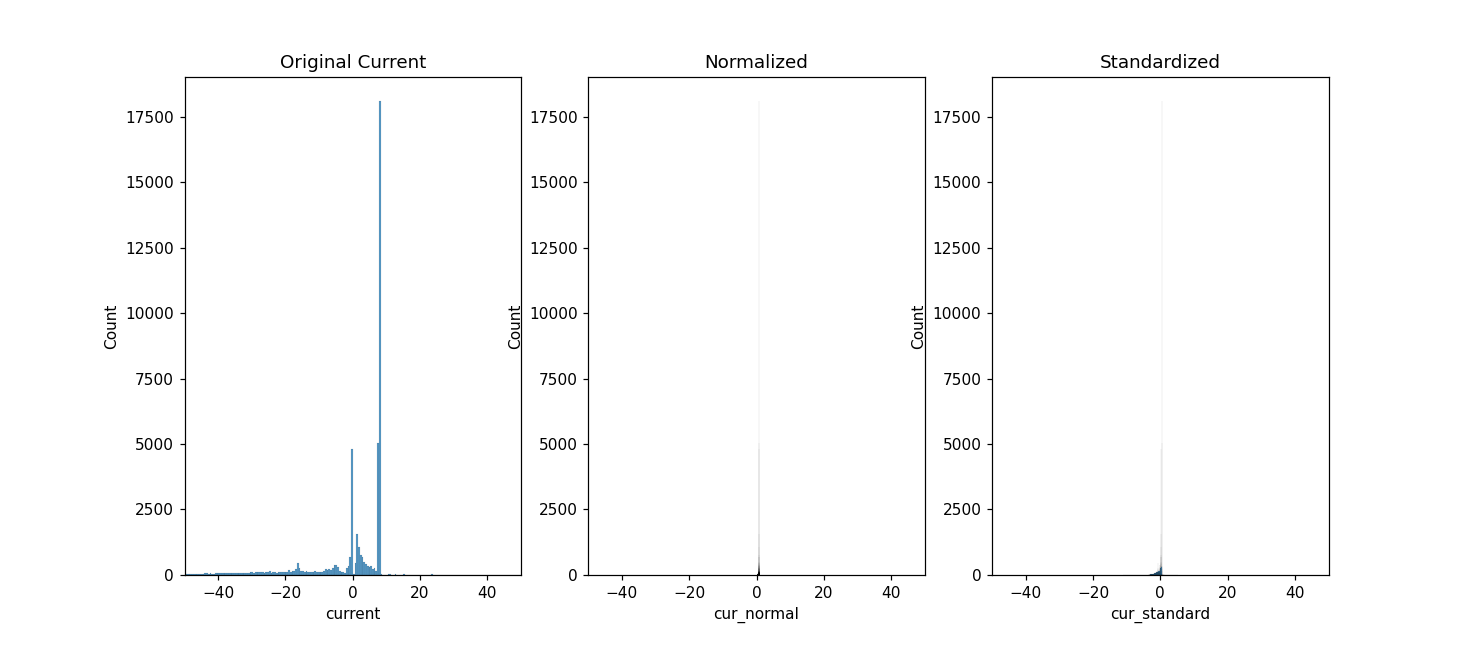

In [54]:
%matplotlib notebook

# Import seaborn
import seaborn as sns

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
sns.histplot(x=df['current'], ax=ax[0])
ax[0].set_title('Original Current')
sns.histplot(x=df['cur_normal'], ax=ax[1])
ax[1].set_title('Normalized')
sns.histplot(x=df['cur_standard'], ax=ax[2])
ax[2].set_title('Standardized')

for i in range(3):
    ax[i].set_xlim([-50, 50])
plt.show()

# df_sine.drop(['feature_normalized', 'feature_standardized'], axis=1, inplace=True)


In [55]:
NUM_EPOCHS = 2000
NUM_NEURONS = 64

def stacked_dropout_LSTM(path, train_X, train_y, iteration_no, num_neurons=32, dropout=0):
    # Seeds
    tf.keras.backend.clear_session()
    seed_value= 0
    os.environ['PYTHONHASHSEED']=str(seed_value)
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)
    K.set_session(sess)

#     model = Sequential()
#     model.add(LSTM(num_neurons, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))   # no use of batch because stateless, input shape=(#samples, #fatures)
#     model.add(LSTM(units=100, return_sequences=False))
#     model.add(Dense(10, 'relu'))
#     model.add(Dense(1, 'linear'))
#     model.summary()

    # LSTM arch same as before
    model = Sequential()
    model.add(LSTM(num_neurons, input_shape=(train_X.shape[1], train_X.shape[2])))   # no use of batch because stateless, input shape=(#samples, #fatures)
#     model.add(Dense(8, 'relu'))
    model.add(Dense(1, 'linear'))
    model.summary()

    # save_best_only=true saves the best model with lowest validation loss
    model_path = os.path.join(path, 'model' + str(iteration_no) + '.h5')
    my_callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=100,verbose=0,mode='min'),  # minimize validation loss
        tf.keras.callbacks.ModelCheckpoint(filepath=model_path, monitor='val_loss', mode='min', save_best_only=True)
    ]

    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

    # measuers performance on every epoch on the validation dataset
    # calls back checkpoint after every epoch and saves model if validation loss is lower than before
    # history = model.fit(train_X, train_y, validation_data=(val_X, val_y), epochs=nb_epoch, callbacks=callback_list)

    history = model.fit(train_X, train_y, epochs=NUM_EPOCHS, verbose=2, shuffle=False, validation_split=0.20, callbacks=my_callbacks)
    data_preprocess.save_object(history, path, 'history' + str(iteration_no) + '.pkl')    # save history

# Train Generic RNN model
model_path = os.path.join(cwd, 'generalized', 'stationary')
stacked_dropout_LSTM(model_path, X, y, '_standard_', NUM_NEURONS, 0)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2000
1221/1221 - 8s - loss: 0.4289 - root_mean_squared_error: 0.6549 - val_loss: 1.8532 - val_root_mean_squared_error: 1.3613 - 8s/epoch - 6ms/step
Epoch 2/2000
1221/1221 - 7s - loss: 0.4624 - root_mean_squared_error: 0.6800 - val_loss: 1.9168 - val_root_mean_squared_error: 1.3845 - 7s/epoch - 6ms/step
Epoch 3/2000
1221/1221 - 5s - loss: 0.4577 - root_mean_squared_error: 0.6765 - val_loss: 1.9376 - val_root_mean_squared_error: 1.3920 - 

Epoch 49/2000
1221/1221 - 10s - loss: 0.3516 - root_mean_squared_error: 0.5930 - val_loss: 1.7951 - val_root_mean_squared_error: 1.3398 - 10s/epoch - 8ms/step
Epoch 50/2000
1221/1221 - 9s - loss: 0.3513 - root_mean_squared_error: 0.5927 - val_loss: 1.7936 - val_root_mean_squared_error: 1.3393 - 9s/epoch - 7ms/step
Epoch 51/2000
1221/1221 - 9s - loss: 0.3511 - root_mean_squared_error: 0.5925 - val_loss: 1.7922 - val_root_mean_squared_error: 1.3387 - 9s/epoch - 7ms/step
Epoch 52/2000
1221/1221 - 9s - loss: 0.3508 - root_mean_squared_error: 0.5922 - val_loss: 1.7911 - val_root_mean_squared_error: 1.3383 - 9s/epoch - 7ms/step
Epoch 53/2000
1221/1221 - 9s - loss: 0.3504 - root_mean_squared_error: 0.5920 - val_loss: 1.7902 - val_root_mean_squared_error: 1.3380 - 9s/epoch - 7ms/step
Epoch 54/2000
1221/1221 - 9s - loss: 0.3501 - root_mean_squared_error: 0.5917 - val_loss: 1.7894 - val_root_mean_squared_error: 1.3377 - 9s/epoch - 7ms/step
Epoch 55/2000
1221/1221 - 10s - loss: 0.3498 - root_mean

Epoch 101/2000
1221/1221 - 8s - loss: 0.3391 - root_mean_squared_error: 0.5823 - val_loss: 1.8046 - val_root_mean_squared_error: 1.3433 - 8s/epoch - 7ms/step
Epoch 102/2000
1221/1221 - 10s - loss: 0.3388 - root_mean_squared_error: 0.5821 - val_loss: 1.8047 - val_root_mean_squared_error: 1.3434 - 10s/epoch - 8ms/step
Epoch 103/2000
1221/1221 - 10s - loss: 0.3386 - root_mean_squared_error: 0.5819 - val_loss: 1.8049 - val_root_mean_squared_error: 1.3435 - 10s/epoch - 8ms/step
Epoch 104/2000
1221/1221 - 8s - loss: 0.3383 - root_mean_squared_error: 0.5817 - val_loss: 1.8051 - val_root_mean_squared_error: 1.3435 - 8s/epoch - 7ms/step
Epoch 105/2000
1221/1221 - 10s - loss: 0.3381 - root_mean_squared_error: 0.5815 - val_loss: 1.8055 - val_root_mean_squared_error: 1.3437 - 10s/epoch - 8ms/step
Epoch 106/2000
1221/1221 - 9s - loss: 0.3379 - root_mean_squared_error: 0.5813 - val_loss: 1.8058 - val_root_mean_squared_error: 1.3438 - 9s/epoch - 7ms/step
Epoch 107/2000
1221/1221 - 10s - loss: 0.3376 

Epoch 153/2000
1221/1221 - 9s - loss: 0.3248 - root_mean_squared_error: 0.5699 - val_loss: 1.8190 - val_root_mean_squared_error: 1.3487 - 9s/epoch - 7ms/step
Epoch 154/2000
1221/1221 - 9s - loss: 0.3243 - root_mean_squared_error: 0.5695 - val_loss: 1.8196 - val_root_mean_squared_error: 1.3489 - 9s/epoch - 7ms/step
Epoch 155/2000
1221/1221 - 9s - loss: 0.3237 - root_mean_squared_error: 0.5690 - val_loss: 1.8204 - val_root_mean_squared_error: 1.3492 - 9s/epoch - 7ms/step
Epoch 156/2000
1221/1221 - 10s - loss: 0.3231 - root_mean_squared_error: 0.5684 - val_loss: 1.8212 - val_root_mean_squared_error: 1.3495 - 10s/epoch - 8ms/step
Epoch 157/2000
1221/1221 - 9s - loss: 0.3224 - root_mean_squared_error: 0.5678 - val_loss: 1.8223 - val_root_mean_squared_error: 1.3499 - 9s/epoch - 8ms/step
Epoch 158/2000
1221/1221 - 9s - loss: 0.3216 - root_mean_squared_error: 0.5671 - val_loss: 1.8237 - val_root_mean_squared_error: 1.3505 - 9s/epoch - 7ms/step
Epoch 159/2000
1221/1221 - 10s - loss: 0.3207 - ro

INFO:tensorflow:Assets written to: ram://277752f2-a5ec-409f-b96e-dd71f06fbb33/assets


In [56]:
# One step ahead predict for standard data
df_test = li_train_cycles[2].copy()
TIMESTEPS = 10

iloc_cntr_on = (df_test['contactor_state'].values != constants.CONTACTOR_OFF).argmax()   # find iloc of first occurance when of contactor_on
df_test = df_test.iloc[iloc_cntr_on:]            # Extract all rows starting from contactor on
# print(len(df_test))

df_test = df_test[['V', 'current', 'Temp']]   # only necessary columns

# statndard
df_test['V_standard'] = StandardScaler().fit_transform(df_test[['V']])
df_test['cur_standard'] = StandardScaler().fit_transform(df_test[['current']])

X, y = df_to_supervised_univariate(df_test['cur_standard'], df_test['V_standard'], TIMESTEPS)     # standard

In [58]:
# 1 step prediction
iteration_no = ''
# FORECAST_SECONDS = len(df_test)
FORECAST_SECONDS = y.shape[0]

model_path = os.path.join(cwd, 'generalized', 'stationary', 'model_standard_' + str(iteration_no) + '.h5')

from keras.models import load_model

model = load_model(model_path)

print(X.shape, y.shape)

lstm_gen_predictions = model.predict(X)
lstm_gen_predictions = np.squeeze(lstm_gen_predictions)

print(lstm_gen_predictions.shape)

(1417, 10, 1) (1417,)
(1417,)


<IPython.core.display.Javascript object>


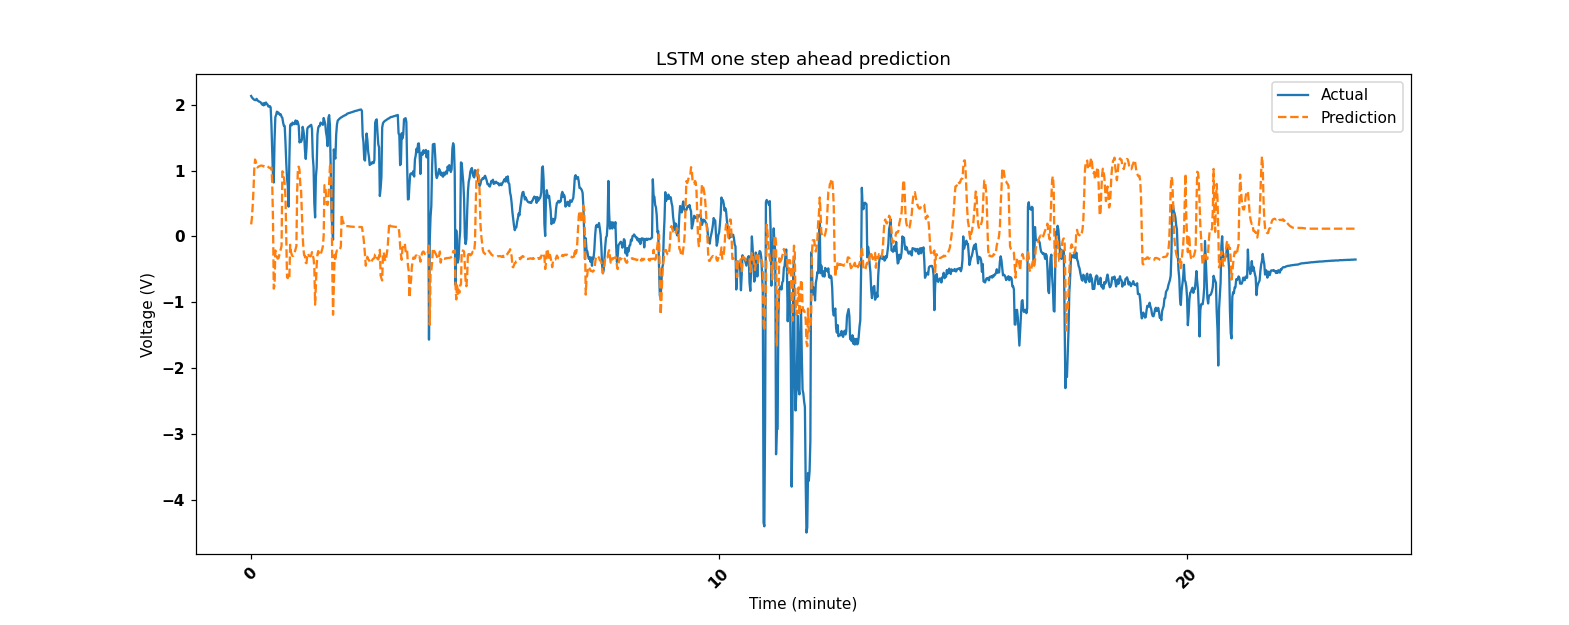

In [59]:
%matplotlib notebook

x_axis = np.arange(lstm_gen_predictions.shape[0])
y = y[:FORECAST_SECONDS]

# This displays result  for concat standardized 1 step ahead pred plot wehre training was not successful

save_path = os.path.join(cwd, 'generalized', 'stationary', 'model_standard_' + str(iteration_no) + '.pdf')
custom_plot.plot_multi_line(("LSTM one step ahead prediction", save_path, "Voltage (V)"), (x_axis, constants.x_label_elapsedtime), (y, "Actual"), (lstm_gen_predictions, "Prediction"))

### normalization and standardization result for single time series: validation loss increases with time.
Hint: plot cwd\generalized\stationary\history_standard_.pkl

### Smoothing: make polynomial

<IPython.core.display.Javascript object>


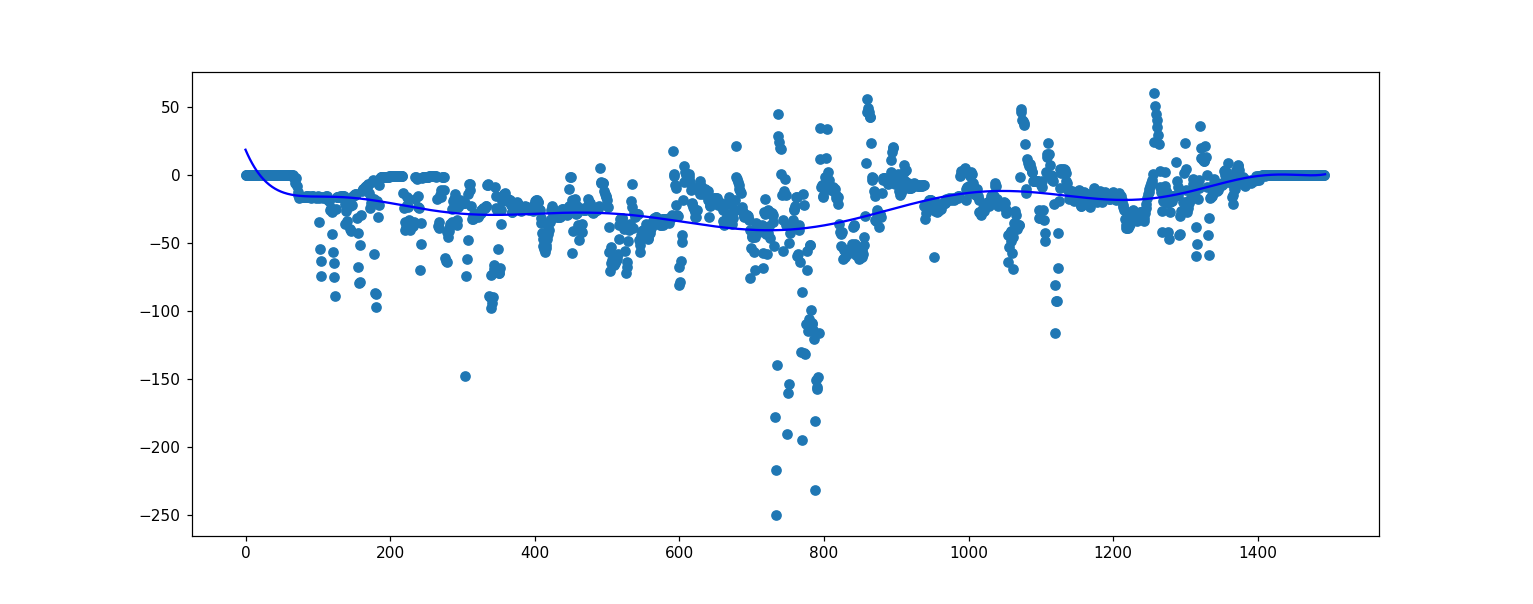

In [16]:
%matplotlib notebook

from statsmodels.tsa.stattools import adfuller
import numpy.polynomial.polynomial as poly

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline


df = li_train_cycles[2].copy()
TIMESTEPS = 10

df = df[['V', 'current', 'Temp', 'elapsed_sec']]   # only necessary columns


plt.scatter(df['elapsed_sec'], df['current'])

#fit polynomial models up to degree 5
# model1 = np.poly1d(np.polyfit(df['elapsed_sec'], df['current'], 1))
# model2 = np.poly1d(np.polyfit(df['elapsed_sec'], df['current'], 2))
# model3 = np.poly1d(np.polyfit(df['elapsed_sec'], df['current'], 3))
# model4 = np.poly1d(np.polyfit(df['elapsed_sec'], df['current'], 4))
# model5 = np.poly1d(np.polyfit(df.x, df.y, 5))
model10 = np.poly1d(np.polyfit(df['elapsed_sec'], df['current'], 10))

#create scatterplot
polyline = np.linspace(0, len(df), len(df))       # (low, high, #total_elements)
# plt.scatter(df.x, df.y)

#add fitted polynomial lines to scatterplot 
# plt.plot(polyline, model1(polyline), color='green')
# plt.plot(polyline, model2(polyline), color='red')
# plt.plot(polyline, model3(polyline), color='purple')
# plt.plot(polyline, model4(polyline), color='blue')
plt.plot(polyline, model10(polyline), color='blue')
# plt.plot(polyline, model5(polyline), color='orange')
plt.show()


# coefs = poly.polyfit(x, y, 2)
# ffit = poly.polyval(x_new, coefs)
# plt.plot(x_new, ffit)


# statndard
# df_test['V_standard'] = StandardScaler().fit_transform(df_test[['V']])
# df_test['cur_standard'] = StandardScaler().fit_transform(df_test[['current']])

# df_transform = df.copy()

# # transform to stationary
# df1 = df_transform['current'].apply(np.log)
# # df1 = np.log(df_transform['current']) # equivalent
# # plot_chart(df1, 'Current (Log)') # equivalent
# df1.plot(kind = 'scatter', x = 'Time', y = 'Current')
# plt.show()


# check stationarity
# result=adfuller (df_diff['current'])
# print('Test Statistic: %f' %result[0])
# print('p-value: %f' %result[1])
# print('Critical values:')
# for key, value in result[4].items ():
#      print('\t%s: %.3f' %(key, value))

# X, y = df_to_supervised_univariate(df_test['cur_standard'], df_test['V_standard'], TIMESTEPS)     # standard

### detrend TS

<IPython.core.display.Javascript object>


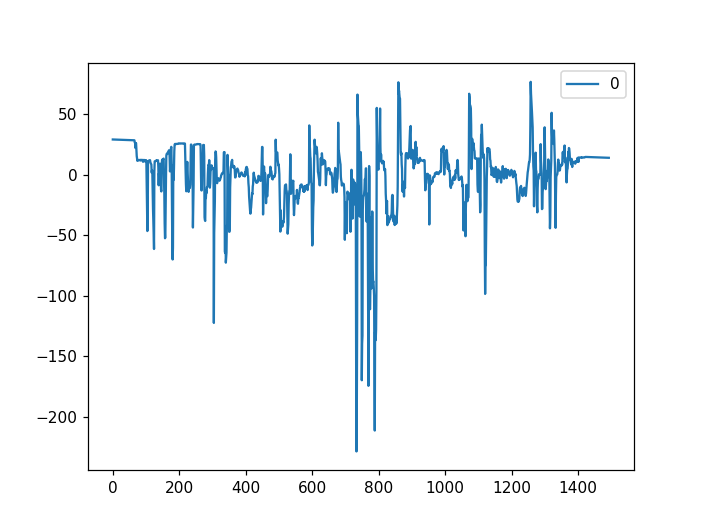

<AxesSubplot:>

In [17]:
from scipy import signal

df = li_train_cycles[2].copy()
TIMESTEPS = 10

df = df[['V', 'current', 'Temp', 'elapsed_sec']]   # only necessary columns

detrended = signal.detrend(df['current'])

detrended_df = pd.DataFrame(detrended)
detrended_df.plot()

### exponential smoothing

C:\Users\s.kaiser\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<IPython.core.display.Javascript object>


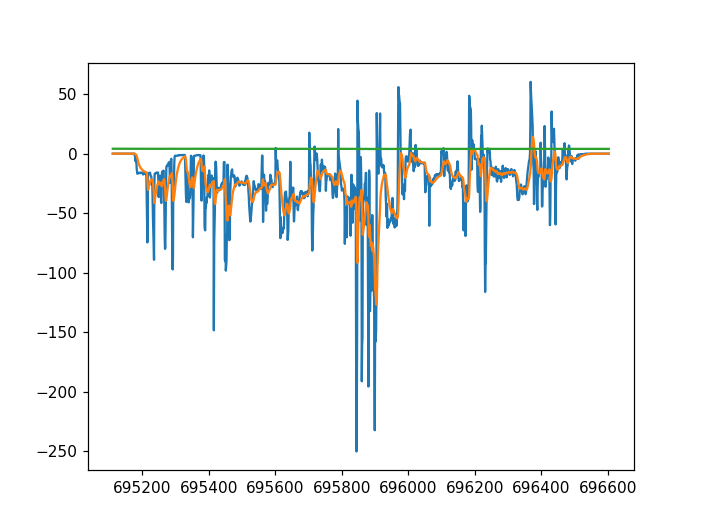

<class 'pandas.core.series.Series'>


In [30]:
%matplotlib notebook

# simple 
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

import matplotlib.pyplot as plt

df = li_train_cycles[2].copy()
TIMESTEPS = 10

df = df[['V', 'current', 'Temp', 'elapsed_sec']]   # only necessary columns

fit1 = SimpleExpSmoothing(df['current']).fit(smoothing_level=0.1, optimized=False)   # smoothing level higher = closer to original
# fit2 = Holt(df['current'], initialization_method="estimated").fit()

df['current_smooth_exp'] = fit1.fittedvalues 

plt.plot(df['current'])
plt.plot(fit1.fittedvalues)
print(type(fit1.fittedvalues))
plt.plot(df['V'])
# plt.plot(fit2.fittedvalues)
plt.show()
